Data:
https://www.kaggle.com/unsdsn/world-happiness#2017.csv
https://worldhappiness.report/ed/2019/
https://www.imf.org/external/pubs/ft/weo/2019/01/weodata/download.aspx

# Import Libraries, CSVs

In [383]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 1000
import numpy as np
import matplotlib as plt
plt.style.use('ggplot')

In [384]:
happiness_2015 = pd.read_csv('/Users/jackmengel/Desktop/Projects/2015.csv')
happiness_2016 = pd.read_csv('/Users/jackmengel/Desktop/Projects/2016.csv')
happiness_2017 = pd.read_csv('/Users/jackmengel/Desktop/Projects/2017.csv')
happiness_2018 = pd.read_csv('/Users/jackmengel/Desktop/Projects/2018.csv')
happiness_2019 = pd.read_csv('/Users/jackmengel/Desktop/Projects/2019.csv')

imf = pd.read_csv('/Users/jackmengel/Desktop/Projects/IMFEconData_20190630.csv', encoding = 'latin1')

# Transform IMF file into usable DataFrame

In [385]:
imf_pivot = imf.transpose()
imf_pivot.columns = imf_pivot.iloc[0]
imf_pivot = imf_pivot.reset_index()
imf_pivot = imf_pivot.drop(0)
imf_pivot.iloc[0,0] = "Year"
imf_pivot.head()

train = pd.DataFrame()
countries = imf['Country'].unique()

for i in countries:
    global imf_pivot
    global train
    
    df = pd.DataFrame(
        columns = ['Year', 'Country']
    )
    df['Year'] = imf_pivot['index'].iloc[1:]
    df['Country'] = i
    
    df = pd.concat(
        [
            df,
            imf_pivot.loc[:, i]
        ],
        axis = 1
    )
    
    df = df.drop(df.index[len(df)-1])
    df.iloc[0,0] = "Year"
    df.iloc[0,1] = "Country"
    df.columns = df.iloc[0]
    df = df.drop(1)
    
    train = pd.concat(
        [
            train,
            df
        ],
        axis = 0
    )
    
train['Year'] = train['Year'].astype('int64')

# Aggregate happiness metrics into one DataFrame

In [386]:
happiness_15 = pd.DataFrame(
    columns = ['Year', 'Country', 'Happiness Score']
)

happiness_15['Country'] = happiness_2015['Country']
happiness_15['Happiness Score'] = happiness_2015['Happiness Score']
happiness_15['Year'] = 2015

happiness_16 = pd.DataFrame(
    columns = ['Year', 'Country', 'Happiness Score']
)

happiness_16['Country'] = happiness_2016['Country']
happiness_16['Happiness Score'] = happiness_2016['Happiness Score']
happiness_16['Year'] = 2016

happiness_17 = pd.DataFrame(
    columns = ['Year', 'Country', 'Happiness Score']
)

happiness_17['Country'] = happiness_2017['Country']
happiness_17['Happiness Score'] = happiness_2017['Happiness.Score']
happiness_17['Year'] = 2017

happiness_18 = pd.DataFrame(
    columns = ['Year', 'Country', 'Happiness Score']
)

happiness_18['Country'] = happiness_2018['Country']
happiness_18['Happiness Score'] = happiness_2018['Happiness score']
happiness_18['Year'] = 2018

happiness_19 = pd.DataFrame(
    columns = ['Year', 'Country', 'Happiness Score']
)

happiness_19['Country'] = happiness_2019['Country']
happiness_19['Happiness Score'] = happiness_2019['Happiness score']
happiness_19['Year'] = 2019

happiness = pd.concat(
    [
        happiness_15,
        happiness_16,
        happiness_17,
        happiness_18,
        happiness_19
    ],
    axis = 0
)

# Join IMF and Happiness Reports
# Update country names in IMF to match Happiness reports

In [387]:
train.loc[train.Country == 'Slovak Republic', 'Country'] = 'Slovakia'
train.loc[train.Country == 'Korea', 'Country'] = 'South Korea'
train.loc[train.Country == 'Taiwan Province of China', 'Country'] = 'Taiwan'
train.loc[train.Country == 'Hong Kong SAR', 'Country'] = 'Hong Kong S.A.R., China'

train = pd.merge(
    train,
    happiness,
    on = ['Year', 'Country'],
    how = 'left'
)

# DQ check: make sure country names are matching
## A few missing i.e. Iran

In [388]:
df1 = pd.DataFrame(
    columns = ['Happiness_Country'],
    data = happiness['Country'].unique()
)

df2 = pd.DataFrame(
    columns = ['IMF_Country'],
    data = train['Country'][train['Happiness Score'] > 0].unique()
)

df3 = pd.merge(
    df1,
    df2,
    left_on = ['Happiness_Country'],
    right_on = ['IMF_Country'],
    how = 'outer'
)

df3[pd.isnull(df3.IMF_Country)]

,Happiness_Country,IMF_Country
65,North Cyprus,NaN
71,Hong Kong,NaN
76,Kyrgyzstan,NaN
90,Somaliland region,NaN
92,Macedonia,NaN
98,Laos,NaN
100,Swaziland,NaN
107,Palestinian Territories,NaN
109,Iran,NaN
119,Congo (Kinshasa),NaN


# Filter for years where we have Happiness data (2015-2019)
# Clean data (remove commas)

In [413]:
train_current = train[(train.Year >= 2015) & (train.Year <= 2019)]

current_cols = train_current.columns.drop(['Country', 'Year', 'Happiness Score'])
train_current[current_cols] = train_current[current_cols].replace(
    {
        ',' : '',
        '--' : ''
    }, 
    regex = True
)
train_current[current_cols] = train_current[current_cols].apply(pd.to_numeric)

/Users/jackmengel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


# Remove columns with sparse data

In [418]:
counts = train_current.count().reset_index()
counts.columns = ['col', 'count']
counts = counts[counts['count'] < (.7 * 970)]
train_current = train_current.drop(counts['col'], axis = 1)

# Run correlation and visualize!

In [419]:
corr = train_current.corr()

happiness_corr = pd.DataFrame(
    columns = ['index', 'Happiness Score'],
    data = corr['Happiness Score'].reset_index()
)
happiness_corr['happiness_abs'] = happiness_corr['Happiness Score'].abs()

print(happiness_corr.sort_values(by = 'happiness_abs', ascending = False))

                                                                                                    index  \
38                                                                                        Happiness Score   
10                                         Gross domestic product per capita, current prices-U.S. dollars   
8   Gross domestic product per capita, constant prices-Purchasing power parity; 2011 international dollar   
11       Gross domestic product per capita, current prices-Purchasing power parity; international dollars   
26                                                              General government revenue-Percent of GDP   
37                                                                 Current account balance-Percent of GDP   
28                                                    General government total expenditure-Percent of GDP   
15                                                                  Gross national savings-Percent of GDP   
4                  

Text(0,0.5,'Govt Revenue (% GDP)')

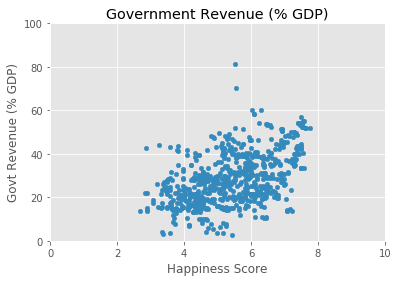

In [422]:
govt_rev = train_current.plot(
    x = 'Happiness Score', 
    y = 'General government revenue-Percent of GDP',
    kind = 'scatter',
    title = 'Government Revenue (% GDP)',
    xlim = [0,10],
    ylim = [0,100]
)
govt_rev.set_xlabel("Happiness Score")
govt_rev.set_ylabel("Govt Revenue (% GDP)")

Text(0,0.5,'GDP per Capita (US Dollars)')

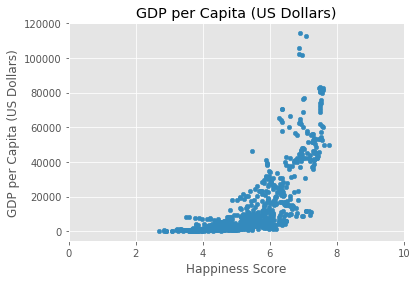

In [429]:
gdp = train_current.plot(
    x = 'Happiness Score', 
    y = 'Gross domestic product per capita, current prices-U.S. dollars',
    kind = 'scatter',
    title = 'GDP per Capita (US Dollars)',
    xlim = [0,10]
)
gdp.set_xlabel("Happiness Score")
gdp.set_ylabel("GDP per Capita (US Dollars)")

Text(0,0.5,'Current Account Balance (% GDP)')

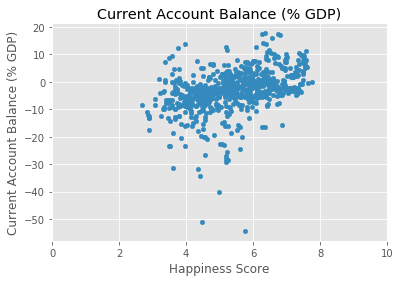

In [432]:
curr_acct = train_current.plot(
    x = 'Happiness Score', 
    y = 'Current account balance-Percent of GDP',
    kind = 'scatter',
    title = 'Current Account Balance (% GDP)',
    xlim = [0,10]
)
curr_acct.set_xlabel("Happiness Score")
curr_acct.set_ylabel("Current Account Balance (% GDP)")